# Modelo de HistGradientBoostingRegressor

Neste notebook será avaliado o desempenho de um modelo de HistGradientBoostingRegressor aplicado à regressão de salários. Esse algoritmo de ensemble baseado em árvores costuma funcionar bem em dados tabulares e permite capturar relações não lineares entre as variáveis. Assim como no caso do MLP, será utilizada validação cruzada para medir a estabilidade do modelo e, ao final, um modelo definitivo será treinado com todos os dados disponíveis.

In [4]:
import json
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor
import joblib
import matplotlib.pyplot as plt

DATA_PATH = "../data/gold/salaries_full.parquet"
ARTIFACTS_DIR = Path("../artifacts/hist")

ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_parquet(DATA_PATH)

features_finais = [
    "experience_level_encoded",
    "company_size_encoded",
    "remote_ratio",
    "is_US",
    "job_type_Full-time",
    "job_type_Contract",
    "job_type_Part-time",
]

features_presentes = [c for c in features_finais if c in df.columns]

if "salary_in_usd" not in df.columns:
    raise ValueError("A coluna 'salary_in_usd' (target) não foi encontrada no dataset.")

X = df[features_presentes].copy()
y = df["salary_in_usd"].values

X = X.astype(float)

print("Features usadas:", features_presentes)
print("Formato de X:", X.shape)
print("Formato de y:", y.shape)


Features usadas: ['experience_level_encoded', 'company_size_encoded', 'remote_ratio', 'is_US', 'job_type_Full-time', 'job_type_Contract', 'job_type_Part-time']
Formato de X: (22789, 7)
Formato de y: (22789,)


## Definição do modelo de HistGradientBoosting e configuração do K-Fold

Nesta etapa é criada uma função que devolve o estimador HistGradientBoostingRegressor com uma configuração inicial de hiperparâmetros. Também é definido o esquema de validação cruzada K-Fold com 10 divisões, o que garante uma avaliação mais robusta do desempenho do modelo em diferentes fatias do conjunto de dados.

In [6]:
def create_model_pipeline():
    model = HistGradientBoostingRegressor(
        learning_rate=0.015,
        max_iter=300,
        max_depth=None,
        random_state=42
    )
    return model

K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=42)


## Treinamento com validação cruzada e cálculo das métricas por fold

Assim como no caso da MLP, o modelo de HistGradientBoosting é treinado seguindo o esquema de validação cruzada K-Fold. Para cada fold são calculadas as métricas de MSE, RMSE, MAE e R² no conjunto de validação, permitindo avaliar a performance do modelo de forma mais completa. Os resultados de cada fold são armazenados e também gravados em arquivos individuais na pasta de artefatos.

In [7]:
fold_metrics = []
best_fold_index = None
best_fold_mse = np.inf

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
    print(f"\n===== Fold {fold_idx}/{K} =====")

    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = create_model_pipeline()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    metrics = {
        "fold": fold_idx,
        "n_train": int(len(train_idx)),
        "n_val": int(len(val_idx)),
        "mse": float(mse),
        "rmse": float(rmse),
        "mae": float(mae),
        "r2": float(r2),
    }
    fold_metrics.append(metrics)

    print("Métricas do fold:")
    print(json.dumps(metrics, indent=4))

    fold_dir = ARTIFACTS_DIR / f"fold_{fold_idx}"
    fold_dir.mkdir(parents=True, exist_ok=True)

    joblib.dump(model, fold_dir / "model.pkl")

    with open(fold_dir / "metrics.json", "w") as f:
        json.dump(metrics, f, indent=4)

    if mse < best_fold_mse:
        best_fold_mse = mse
        best_fold_index = fold_idx

print("\n===== Resumo K-Fold =====")
for m in fold_metrics:
    print(
        f"Fold {m['fold']}: MSE={m['mse']:.2f}, RMSE={m['rmse']:.2f}, "
        f"MAE={m['mae']:.2f}, R2={m['r2']:.4f}"
    )

mse_values = [m["mse"] for m in fold_metrics]
rmse_values = [m["rmse"] for m in fold_metrics]
mae_values = [m["mae"] for m in fold_metrics]
r2_values = [m["r2"] for m in fold_metrics]
fold_ids = [m["fold"] for m in fold_metrics]

mean_mse = float(np.mean(mse_values))
mean_rmse = float(np.mean(rmse_values))
mean_mae = float(np.mean(mae_values))
mean_r2 = float(np.mean(r2_values))

summary_metrics = {
    "k": K,
    "mean_mse": mean_mse,
    "mean_rmse": mean_rmse,
    "mean_mae": mean_mae,
    "mean_r2": mean_r2,
    "best_fold": int(best_fold_index),
    "best_fold_mse": float(best_fold_mse),
}

print("\nMédias das métricas nos 10 folds:")
print(json.dumps(summary_metrics, indent=4))

with open(ARTIFACTS_DIR / "kfold_summary.json", "w") as f:
    json.dump(summary_metrics, f, indent=4)



===== Fold 1/10 =====
Métricas do fold:
{
    "fold": 1,
    "n_train": 20510,
    "n_val": 2279,
    "mse": 1022425345.7484342,
    "rmse": 31975.38656136051,
    "mae": 26136.778014827345,
    "r2": 0.3776964137504458
}

===== Fold 2/10 =====
Métricas do fold:
{
    "fold": 2,
    "n_train": 20510,
    "n_val": 2279,
    "mse": 1028209436.6051006,
    "rmse": 32065.70499154978,
    "mae": 26459.897289821754,
    "r2": 0.3845116387585552
}

===== Fold 3/10 =====
Métricas do fold:
{
    "fold": 3,
    "n_train": 20510,
    "n_val": 2279,
    "mse": 1021907934.00688,
    "rmse": 31967.294755841947,
    "mae": 26505.094201439984,
    "r2": 0.38839442230731047
}

===== Fold 4/10 =====
Métricas do fold:
{
    "fold": 4,
    "n_train": 20510,
    "n_val": 2279,
    "mse": 992486743.2718565,
    "rmse": 31503.757605591378,
    "mae": 26192.25212819652,
    "r2": 0.40332350115223825
}

===== Fold 5/10 =====
Métricas do fold:
{
    "fold": 5,
    "n_train": 20510,
    "n_val": 2279,
    "mse"

## Visualização das métricas por fold

Para entender melhor a variação de desempenho entre os folds, são gerados gráficos de linha para cada métrica. Esses gráficos permitem avaliar se há estabilidade nas medidas de erro e no R² ou se algum fold específico apresenta comportamento muito diferente dos demais. As imagens resultantes são salvas na pasta de artefatos associada ao modelo de HistGradientBoosting.

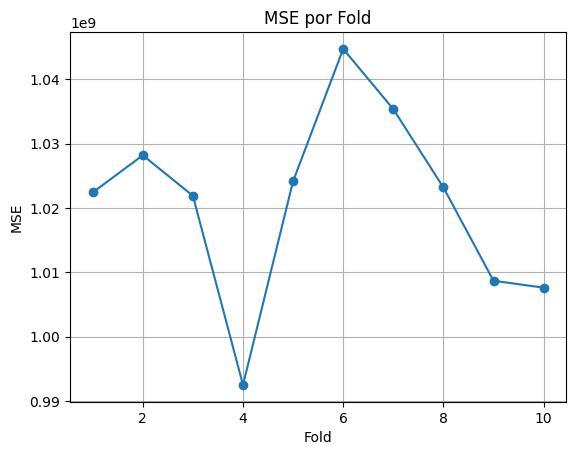

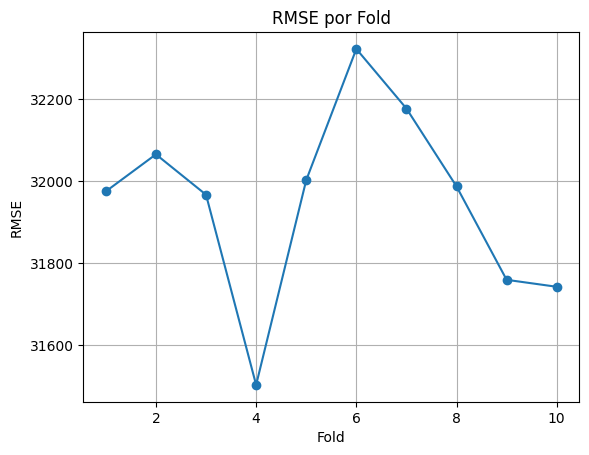

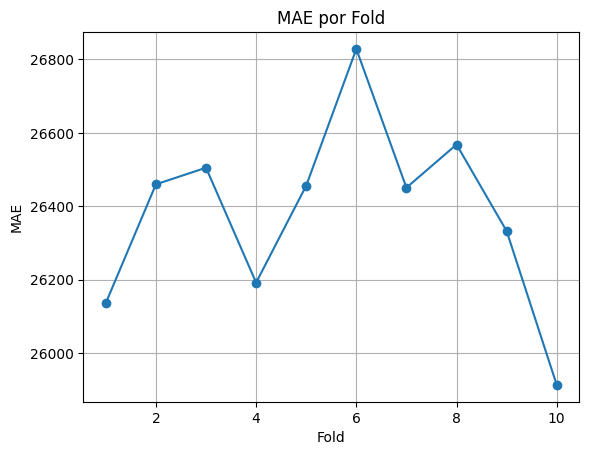

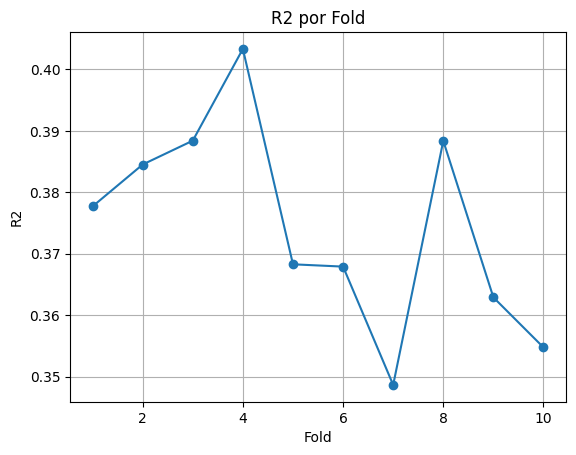

In [13]:
plt.figure()
plt.plot(fold_ids, mse_values, marker="o")
plt.xlabel("Fold")
plt.ylabel("MSE")
plt.title("MSE por Fold")
plt.grid(True)
plt.savefig(ARTIFACTS_DIR / "mse_per_fold.png", bbox_inches="tight")
plt.show()
plt.close()

plt.figure()
plt.plot(fold_ids, rmse_values, marker="o")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("RMSE por Fold")
plt.grid(True)
plt.savefig(ARTIFACTS_DIR / "rmse_per_fold.png", bbox_inches="tight")
plt.show()
plt.close()

plt.figure()
plt.plot(fold_ids, mae_values, marker="o")
plt.xlabel("Fold")
plt.ylabel("MAE")
plt.title("MAE por Fold")
plt.grid(True)
plt.savefig(ARTIFACTS_DIR / "mae_per_fold.png", bbox_inches="tight")
plt.show()
plt.close()

plt.figure()
plt.plot(fold_ids, r2_values, marker="o")
plt.xlabel("Fold")
plt.ylabel("R2")
plt.title("R2 por Fold")
plt.grid(True)
plt.savefig(ARTIFACTS_DIR / "r2_per_fold.png", bbox_inches="tight")
plt.show()
plt.close()


## Treinamento do modelo final em full-data

Depois de avaliar o comportamento do modelo nos diferentes folds, é ajustado um modelo final usando todo o conjunto de dados disponível. Esse modelo concentra o máximo de informação possível e serve como base para análises mais detalhadas de predição. As métricas globais desse modelo final são calculadas e salvas, permitindo comparações diretas com outros algoritmos treinados sobre o mesmo problema.

In [9]:
print("\n===== Treinando modelo final em full-data =====")

final_model = create_model_pipeline()
final_model.fit(X, y)

y_pred_full = final_model.predict(X)

final_mse = mean_squared_error(y, y_pred_full)
final_rmse = np.sqrt(final_mse)
final_mae = mean_absolute_error(y, y_pred_full)
final_r2 = r2_score(y, y_pred_full)

final_metrics = {
    "mse": float(final_mse),
    "rmse": float(final_rmse),
    "mae": float(final_mae),
    "r2": float(final_r2),
}

print("\n===== Métricas do Modelo Final (full-data) =====")
print(json.dumps(final_metrics, indent=4))

with open(ARTIFACTS_DIR / "final_model_metrics.json", "w") as f:
    json.dump(final_metrics, f, indent=4)

joblib.dump(final_model, ARTIFACTS_DIR / "final_model.pkl")

print("Modelo final salvo em:", ARTIFACTS_DIR / "final_model.pkl")
print("Resumo das métricas de K-Fold salvo em:", ARTIFACTS_DIR / "kfold_summary.json")
print("Métricas do modelo final salvas em:", ARTIFACTS_DIR / "final_model_metrics.json")



===== Treinando modelo final em full-data =====

===== Métricas do Modelo Final (full-data) =====
{
    "mse": 1015981448.5887809,
    "rmse": 31874.463894923487,
    "mae": 26315.939177869153,
    "r2": 0.3779722460085603
}
Modelo final salvo em: ../artifacts/hist/final_model.pkl
Resumo das métricas de K-Fold salvo em: ../artifacts/hist/kfold_summary.json
Métricas do modelo final salvas em: ../artifacts/hist/final_model_metrics.json


## Gráficos de Predito vs Observado e Resíduos vs Predito

Em seguida são gerados os gráficos de Predito vs Observado e de Resíduos vs Predito para o modelo final de HistGradientBoosting. O primeiro gráfico ajuda a visualizar o quão próximas estão as previsões em relação aos valores reais de salário. Já o gráfico de resíduos permite identificar possíveis padrões de erro, como desvios sistemáticos em determinadas faixas de salário ou heterocedasticidade nos resíduos.

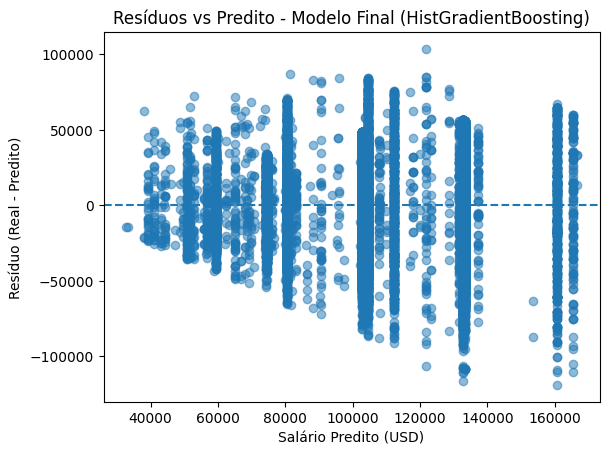

In [11]:
plt.figure()
plt.scatter(y, y_pred_full, alpha=0.5)
min_val = min(y.min(), y_pred_full.min())
max_val = max(y.max(), y_pred_full.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
plt.xlabel("Salário Real (USD)")
plt.ylabel("Salário Predito (USD)")
plt.title("Salário Real vs Predito - Modelo Final (HistGradientBoosting)")
plt.savefig(ARTIFACTS_DIR / "final_pred_vs_true.png", bbox_inches="tight")
plt.close()

residuals = y - y_pred_full

plt.figure()
plt.scatter(y_pred_full, residuals, alpha=0.5)
plt.axhline(0, linestyle="--")
plt.xlabel("Salário Predito (USD)")
plt.ylabel("Resíduo (Real - Predito)")
plt.title("Resíduos vs Predito - Modelo Final (HistGradientBoosting)")
plt.savefig(ARTIFACTS_DIR / "final_residuals_vs_pred.png", bbox_inches="tight")
plt.show()
plt.close()


## Curva de aprendizado

Assim como no modelo de MLP, também é possível gerar uma curva de aprendizado para o HistGradientBoostingRegressor. Esse tipo de gráfico mostra como o desempenho em treino e validação evolui à medida que aumentamos o número de exemplos usados no treinamento. Como o custo computacional é mais elevado, o código permanece comentado e pode ser ativado apenas quando houver necessidade específica dessa análise.

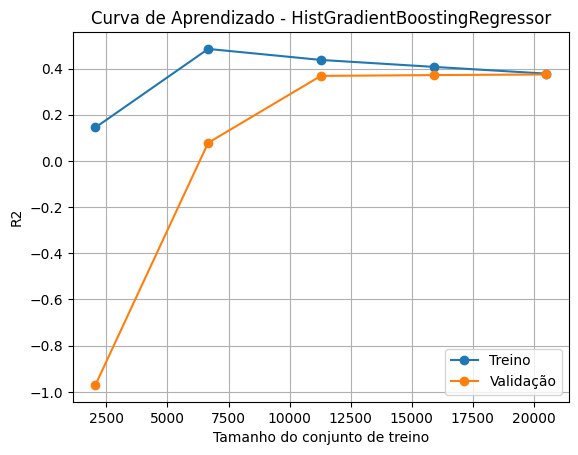

In [12]:
train_sizes, train_scores, val_scores = learning_curve(
    create_model_pipeline(),
    X,
    y,
    cv=KFold(n_splits=K, shuffle=True, random_state=42),
    scoring="r2",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=None,
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, marker="o", label="Treino")
plt.plot(train_sizes, val_scores_mean, marker="o", label="Validação")
plt.xlabel("Tamanho do conjunto de treino")
plt.ylabel("R2")
plt.title("Curva de Aprendizado - HistGradientBoostingRegressor")
plt.legend()
plt.grid(True)
plt.savefig(ARTIFACTS_DIR / "learning_curve.png", bbox_inches="tight")
plt.show()
plt.close()